Loading Fashion MNIST dataset...
Using 5000 training samples and 1000 test samples
Reduced image size: 14x14
Creating simplified LSTM model...
Starting training with 5000 samples, batch size 64, and 10 epochs
Starting training...
Epoch 1/10, Batch 1/78, Loss: 0.4489
Epoch 1/10, Batch 16/78, Loss: 0.3492
Epoch 1/10, Batch 31/78, Loss: 0.3377
Epoch 1/10, Batch 46/78, Loss: 0.3269
Epoch 1/10, Batch 61/78, Loss: 0.4072
Epoch 1/10, Batch 76/78, Loss: 0.2766
Epoch 1/10 completed in 7.92s
Loss: 0.3237, Accuracy: 0.5300, Precision: 0.6222, F1 Score: 0.4970
Total time elapsed: 7.92s
Epoch 2/10, Batch 1/78, Loss: 0.3088
Epoch 2/10, Batch 16/78, Loss: 0.2057
Epoch 2/10, Batch 31/78, Loss: 0.2051
Epoch 2/10, Batch 46/78, Loss: 0.2406
Epoch 2/10, Batch 61/78, Loss: 0.2492
Epoch 2/10, Batch 76/78, Loss: 0.1822
Epoch 2/10 completed in 9.14s
Loss: 0.2213, Accuracy: 0.7220, Precision: 0.7086, F1 Score: 0.7097
Total time elapsed: 17.06s
Epoch 3/10, Batch 1/78, Loss: 0.1356
Epoch 3/10, Batch 16/78, Loss:

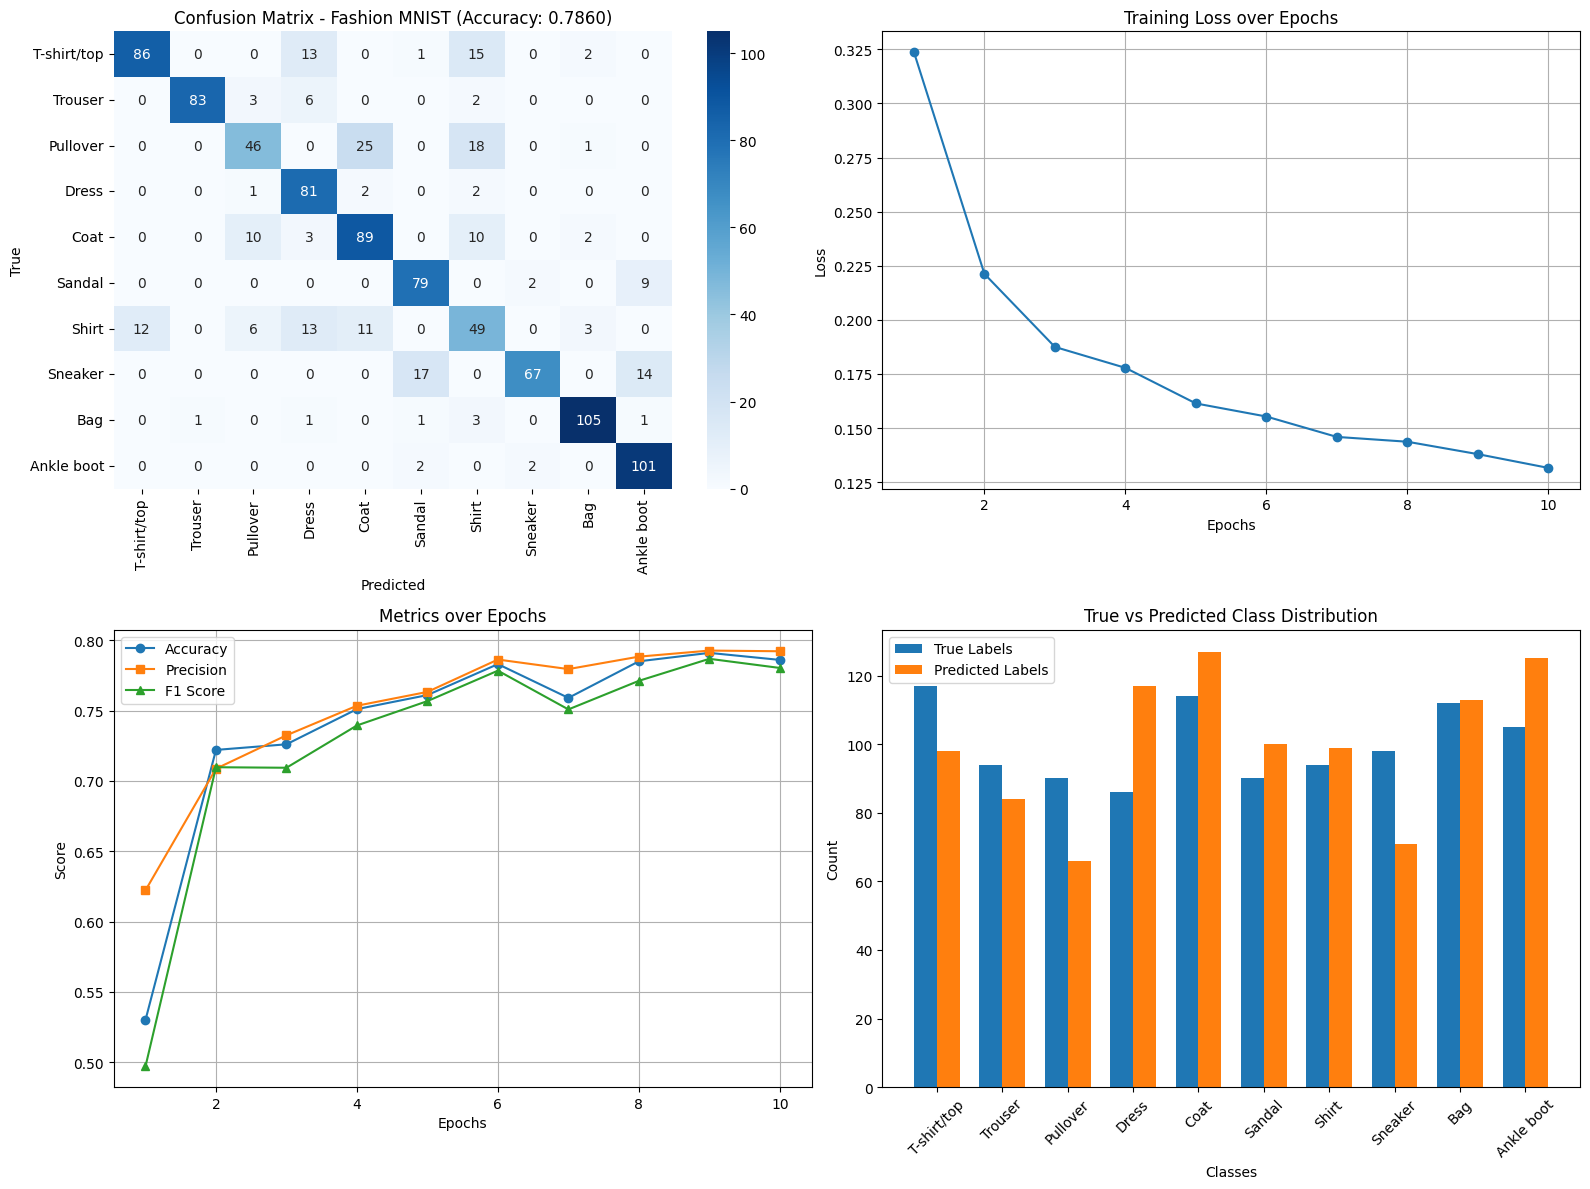

Visualizing true and predicted images...


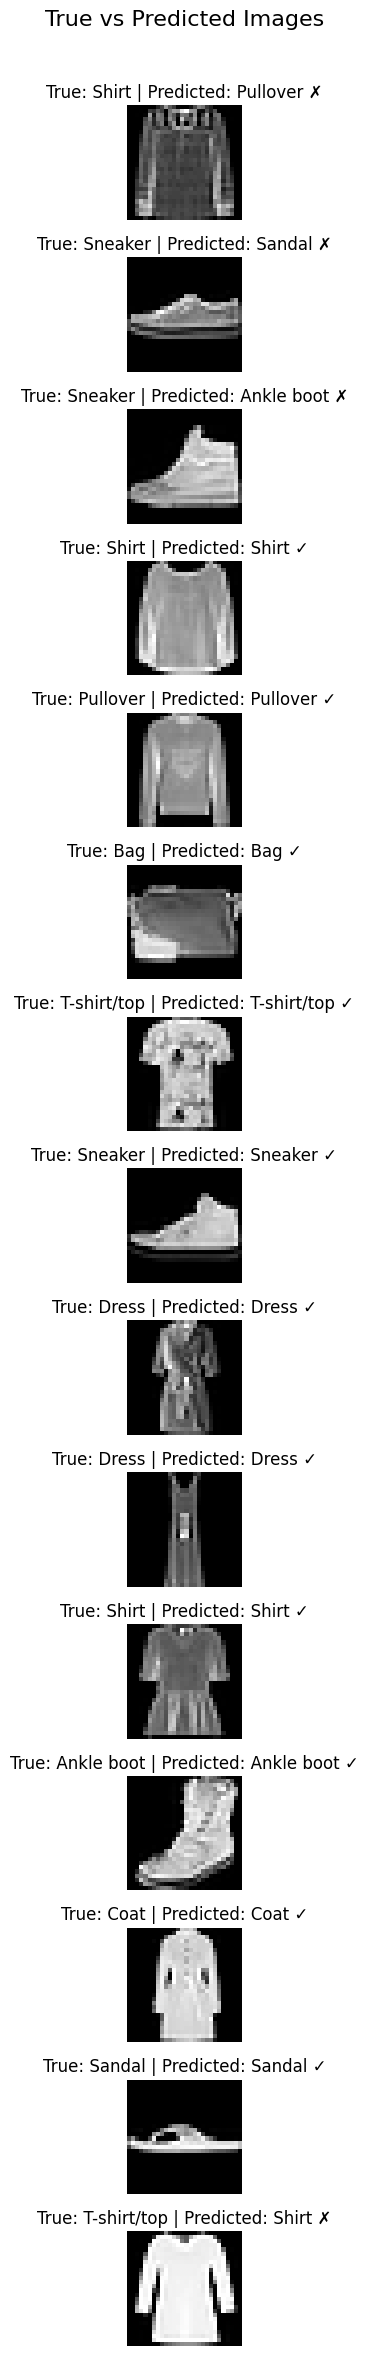

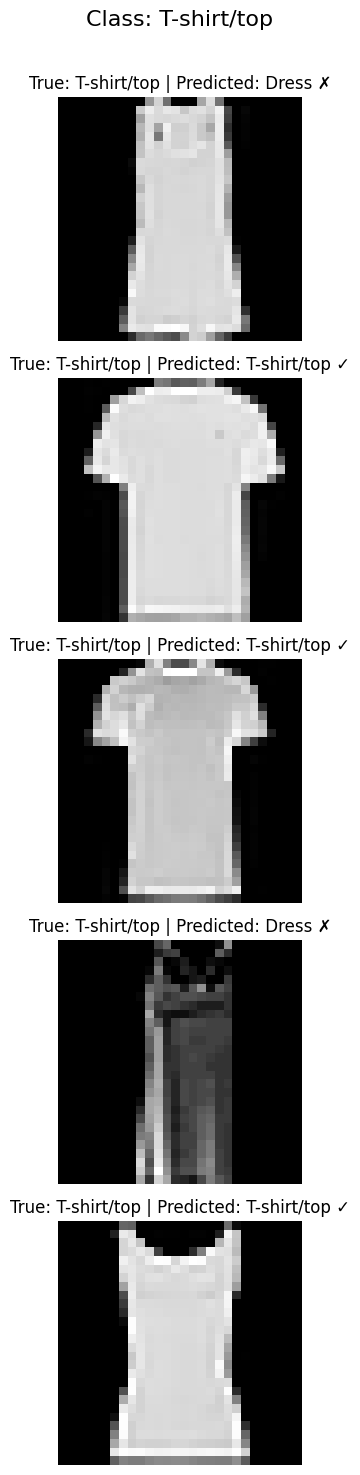

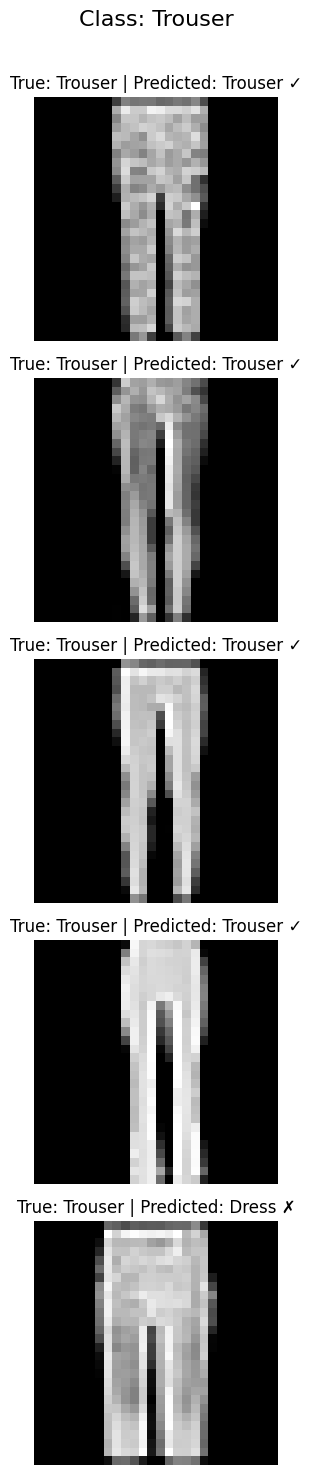

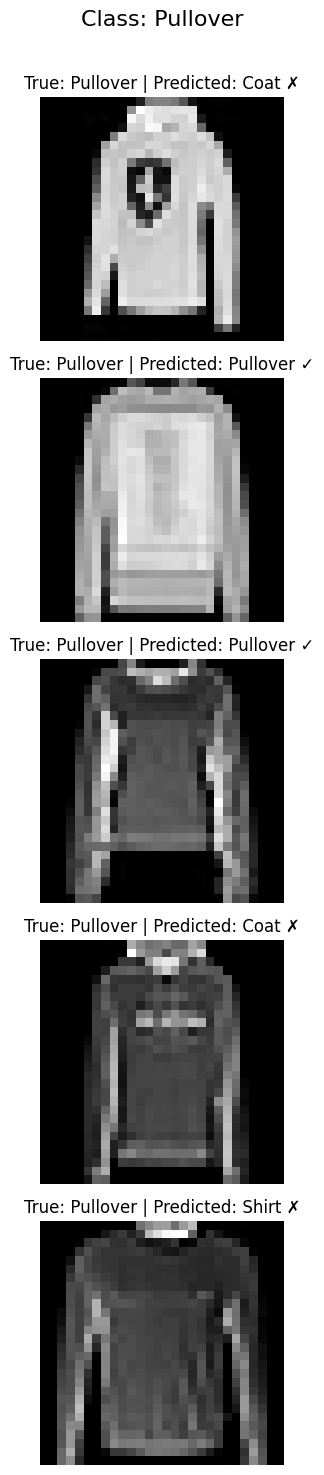

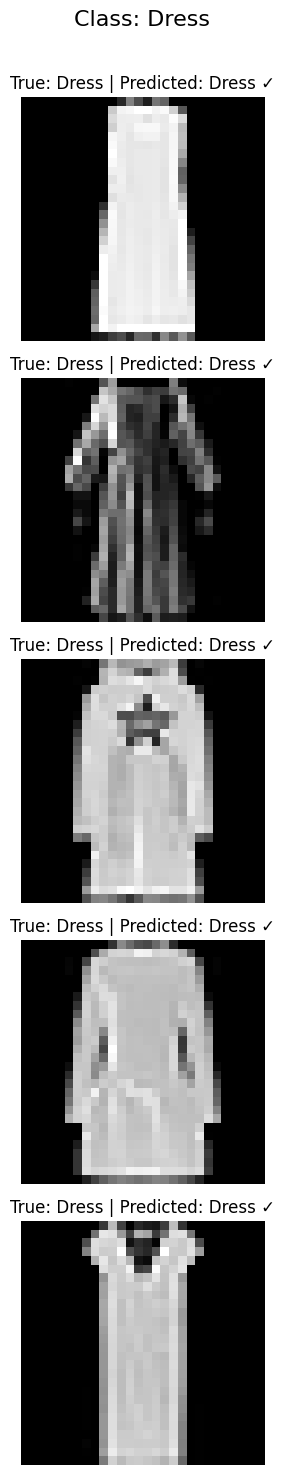

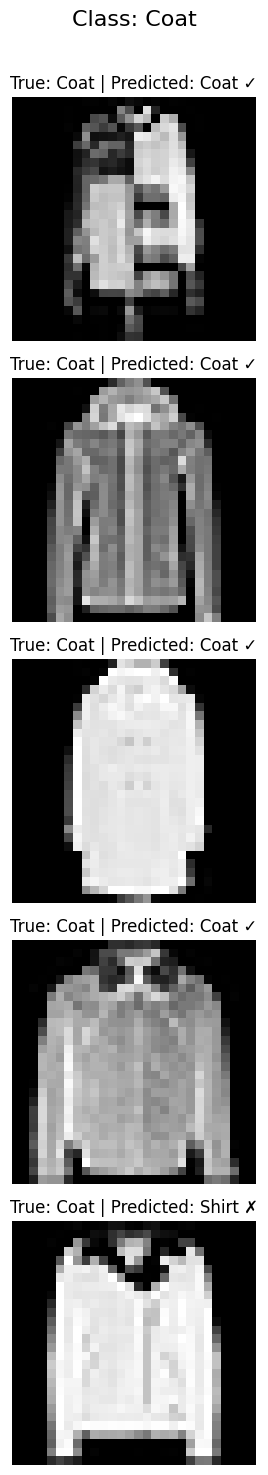

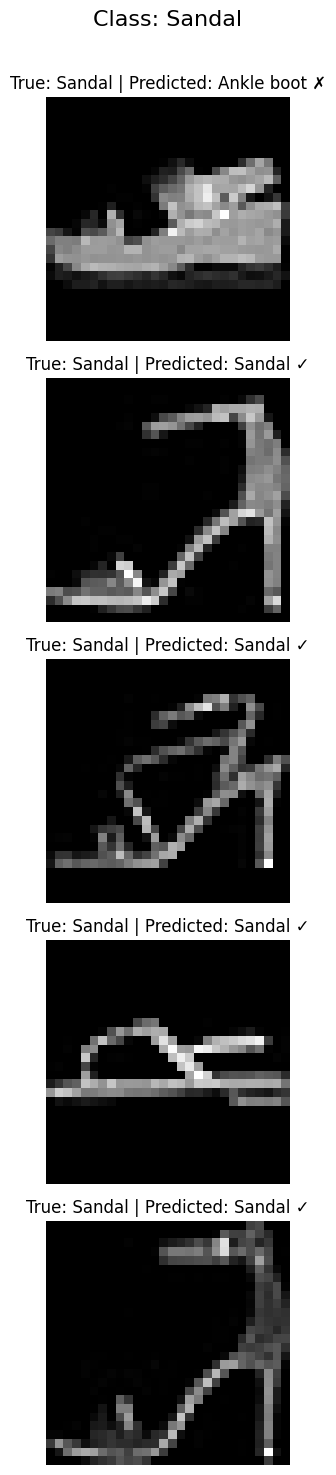

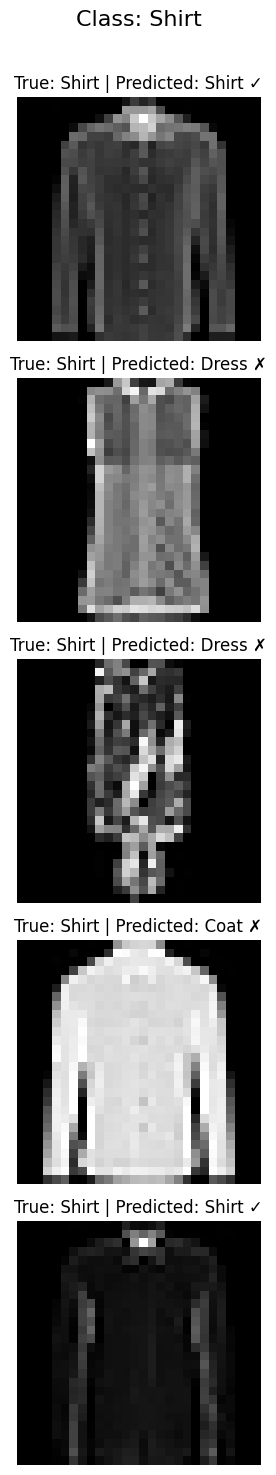

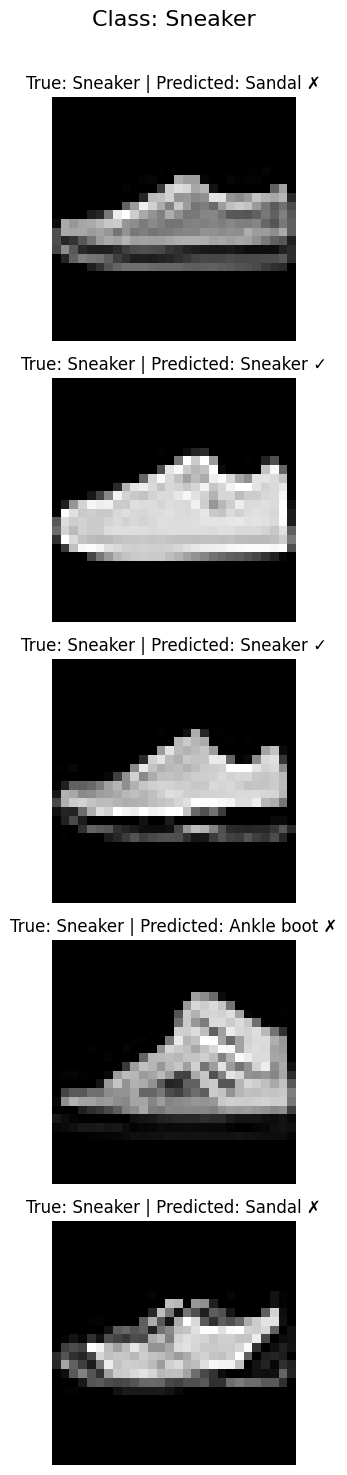

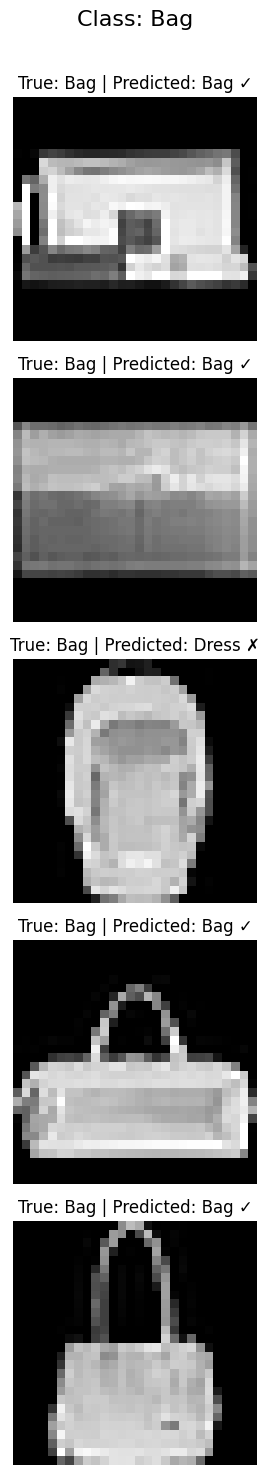

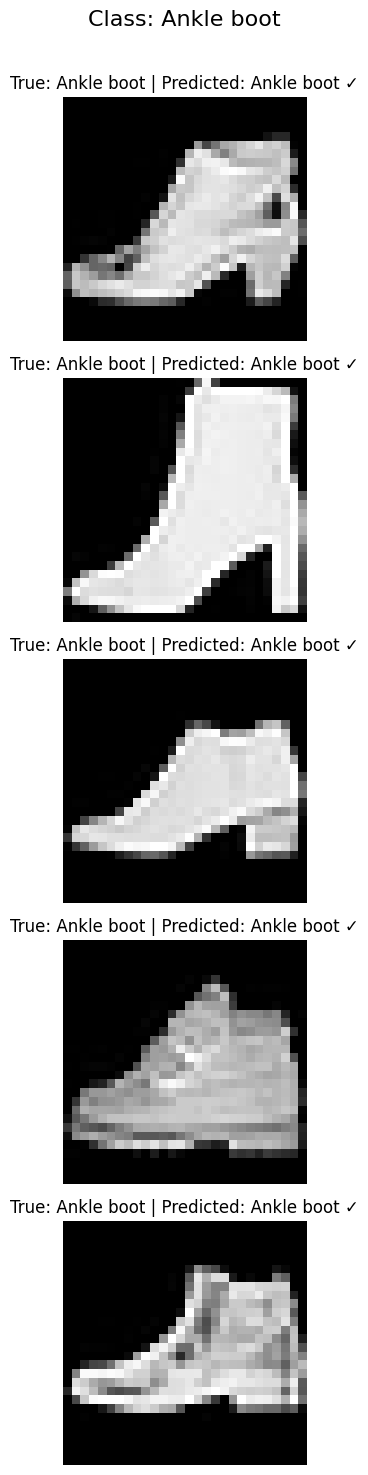

Training complete!
Final accuracy: 0.7860
Final precision: 0.7922
Final F1 score: 0.7803
Total training time: 82.40 seconds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, f1_score, classification_report
import time

# Set random seed for reproducibility
np.random.seed(42)

# Load Fashion MNIST dataset using Keras
print("Loading Fashion MNIST dataset...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Fashion MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Further reduce dataset size for faster execution
train_size = 5000  # Use only 5000 training examples
test_size = 1000  # Use only 1000 test examples

# Randomly sample indices
train_indices = np.random.choice(X_train.shape[0], size=train_size, replace=False)
test_indices = np.random.choice(X_test.shape[0], size=test_size, replace=False)

X_train = X_train[train_indices]
y_train = y_train[train_indices]
X_test = X_test[test_indices]
y_test = y_test[test_indices]

print(f"Using {train_size} training samples and {test_size} test samples")

# Store original test images before preprocessing for later visualization
X_test_original = X_test.copy()

# Data preprocessing
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reduce dimensionality to speed up training
# Take every other row and column (downsampling by factor of 2)
X_train = X_train[:, ::2, ::2]
X_test = X_test[:, ::2, ::2]

print(f"Reduced image size: {X_train.shape[1]}x{X_train.shape[2]}")

# Reshape data for LSTM input (each row is a timestep)
timesteps = X_train.shape[1]  # Number of rows (14 after downsampling)
features = X_train.shape[2]   # Number of columns (14 after downsampling)

X_train = X_train.reshape(X_train.shape[0], timesteps, features)
X_test = X_test.reshape(X_test.shape[0], timesteps, features)

# Convert labels to one-hot encoding
def to_one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_one_hot = to_one_hot(y_train)
y_test_one_hot = to_one_hot(y_test)

# Parameters for fast training
input_size = features      # Each row is a time step
hidden_size = 128          # Reduced hidden size for faster computation
output_size = 10           # 10 classes
learning_rate = 0.01       # Higher learning rate for faster convergence
batch_size = 64            # Balanced batch size
epochs = 10

# Helper functions with optimized implementations
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -10, 10)))

def dsigmoid(y):
    return y * (1 - y)

def tanh(x):
    return np.tanh(x)

def dtanh(y):
    return 1 - y * y

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    m = y_pred.shape[0]
    epsilon = 1e-10
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    log_likelihood = -np.log(np.sum(y_pred * y_true, axis=1))
    return np.sum(log_likelihood) / m

# Efficient Xavier/Glorot initialization
def xavier_init(fan_in, fan_out):
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

# Simplified LSTM implementation for speed
class SimplifiedLSTM:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights for combined gates (more efficient)
        # Combined weights for [forget, input, candidate, output] gates
        self.Wx = xavier_init(input_size, 4 * hidden_size)
        self.Wh = xavier_init(hidden_size, 4 * hidden_size)

        # Biases - with forget gate bias initialized to 1.0
        self.b = np.zeros((1, 4 * hidden_size))
        self.b[:, :hidden_size] = 1.0  # Forget gate bias

        # Output layer
        self.Wy = xavier_init(hidden_size, output_size)
        self.by = np.zeros((1, output_size))

        # Store dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_size)
        batch_size, time_steps, _ = x.shape

        # Initialize hidden state and cell state
        h = np.zeros((batch_size, self.hidden_size))
        c = np.zeros((batch_size, self.hidden_size))

        # Pre-allocate memory for all hidden states (for backprop)
        h_states = np.zeros((batch_size, time_steps + 1, self.hidden_size))
        c_states = np.zeros((batch_size, time_steps + 1, self.hidden_size))

        # Store gate values for backpropagation
        f_gates = np.zeros((batch_size, time_steps, self.hidden_size))
        i_gates = np.zeros((batch_size, time_steps, self.hidden_size))
        c_tildes = np.zeros((batch_size, time_steps, self.hidden_size))
        o_gates = np.zeros((batch_size, time_steps, self.hidden_size))

        # Set initial states
        h_states[:, 0, :] = h
        c_states[:, 0, :] = c

        # Forward pass through time steps
        for t in range(time_steps):
            # Concatenate operations for efficiency
            concat = np.dot(x[:, t, :], self.Wx) + np.dot(h, self.Wh) + self.b

            # Split the concatenated result into the four gates
            f_gate = sigmoid(concat[:, :self.hidden_size])
            i_gate = sigmoid(concat[:, self.hidden_size:2*self.hidden_size])
            c_tilde = tanh(concat[:, 2*self.hidden_size:3*self.hidden_size])
            o_gate = sigmoid(concat[:, 3*self.hidden_size:])

            # Update cell state
            c = f_gate * c + i_gate * c_tilde

            # Update hidden state
            h = o_gate * tanh(c)

            # Store states and gates for backprop
            h_states[:, t+1, :] = h
            c_states[:, t+1, :] = c

            f_gates[:, t, :] = f_gate
            i_gates[:, t, :] = i_gate
            c_tildes[:, t, :] = c_tilde
            o_gates[:, t, :] = o_gate

        # Final output
        y_pred = np.dot(h, self.Wy) + self.by
        probs = softmax(y_pred)

        # Cache for backward pass
        self.cache = {
            'x': x,
            'h_states': h_states,
            'c_states': c_states,
            'f_gates': f_gates,
            'i_gates': i_gates,
            'c_tildes': c_tildes,
            'o_gates': o_gates,
            'probs': probs
        }

        return probs

    def backward(self, y_true, learning_rate=0.01):
        # Retrieve cached values
        x = self.cache['x']
        h_states = self.cache['h_states']
        c_states = self.cache['c_states']
        f_gates = self.cache['f_gates']
        i_gates = self.cache['i_gates']
        c_tildes = self.cache['c_tildes']
        o_gates = self.cache['o_gates']
        probs = self.cache['probs']

        batch_size, time_steps, _ = x.shape

        # Initialize gradients
        dWx = np.zeros_like(self.Wx)
        dWh = np.zeros_like(self.Wh)
        db = np.zeros_like(self.b)
        dWy = np.zeros_like(self.Wy)
        dby = np.zeros_like(self.by)

        # Gradient for output layer
        dout = probs - y_true  # Direct gradient of softmax + cross-entropy
        dWy = np.dot(h_states[:, -1, :].T, dout)
        dby = np.sum(dout, axis=0, keepdims=True)

        # Initialize gradients for hidden state and cell state
        dh_next = np.dot(dout, self.Wy.T)
        dc_next = np.zeros((batch_size, self.hidden_size))

        # Backpropagation through time with faster vectorized operations
        for t in reversed(range(time_steps)):
            # Current hidden state and cell state
            h_prev = h_states[:, t, :]
            c_prev = c_states[:, t, :]
            h = h_states[:, t+1, :]
            c = c_states[:, t+1, :]

            # Current gate values
            f_gate = f_gates[:, t, :]
            i_gate = i_gates[:, t, :]
            c_tilde = c_tildes[:, t, :]
            o_gate = o_gates[:, t, :]

            # Gradient for output gate
            do = dh_next * tanh(c)
            do_input = do * dsigmoid(o_gate)

            # Gradient for cell state
            dc = dc_next + dh_next * o_gate * dtanh(tanh(c))

            # Gradient for forget gate
            df = dc * c_prev
            df_input = df * dsigmoid(f_gate)

            # Gradient for input gate
            di = dc * c_tilde
            di_input = di * dsigmoid(i_gate)

            # Gradient for candidate cell state
            dc_tilde = dc * i_gate
            dc_tilde_input = dc_tilde * dtanh(c_tilde)

            # Combine gate gradients for efficient weight updates
            dgate = np.concatenate((df_input, di_input, dc_tilde_input, do_input), axis=1)

            # Gradients for weights
            dWx += np.dot(x[:, t, :].T, dgate)
            dWh += np.dot(h_prev.T, dgate)
            db += np.sum(dgate, axis=0, keepdims=True)

            # Gradient for input at this time step
            dx_t = np.dot(dgate, self.Wx.T)

            # Gradient for hidden state at previous time step
            dh_prev = np.dot(dgate, self.Wh.T)

            # Gradient for cell state at previous time step
            dc_prev = dc * f_gate

            # Set up for next iteration
            dh_next = dh_prev
            dc_next = dc_prev

        # Update parameters with gradient clipping
        def clip_grad(grad):
            return np.clip(grad, -5, 5)

        # Update model parameters
        self.Wx -= learning_rate * clip_grad(dWx)
        self.Wh -= learning_rate * clip_grad(dWh)
        self.b -= learning_rate * clip_grad(db)
        self.Wy -= learning_rate * clip_grad(dWy)
        self.by -= learning_rate * clip_grad(dby)

        return np.sum((probs - y_true) ** 2) / (2 * batch_size)  # Return MSE for monitoring

    def train(self, X_train, y_train, X_test, y_test, learning_rate, batch_size, epochs):
        num_samples = X_train.shape[0]
        num_batches = num_samples // batch_size

        # Training history
        train_losses = []
        test_accuracies = []
        test_precisions = []
        test_f1_scores = []

        # Time tracking
        start_total = time.time()

        print("Starting training...")
        for epoch in range(epochs):
            epoch_start = time.time()

            # Learning rate decay
            current_lr = learning_rate / (1 + 0.2 * epoch)

            # Shuffle training data
            indices = np.random.permutation(num_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]

            epoch_loss = 0

            # Training loop with batch processing
            for batch in range(num_batches):
                batch_start = batch * batch_size
                batch_end = min(batch_start + batch_size, num_samples)

                X_batch = X_train_shuffled[batch_start:batch_end]
                y_batch = y_train_shuffled[batch_start:batch_end]

                # Forward pass
                probs = self.forward(X_batch)

                # Backward pass with parameter update
                batch_loss = self.backward(y_batch, current_lr)
                epoch_loss += batch_loss

                # Print progress less frequently
                if batch % max(1, num_batches // 5) == 0:
                    print(f"Epoch {epoch+1}/{epochs}, Batch {batch+1}/{num_batches}, Loss: {batch_loss:.4f}")

            # Compute average loss for epoch
            avg_loss = epoch_loss / num_batches
            train_losses.append(avg_loss)

            # Evaluate on test set
            correct = 0
            all_predictions = []
            all_true_labels = []

            for i in range(0, len(X_test), batch_size):
                X_test_batch = X_test[i:i+batch_size]
                y_test_batch = y_test[i:i+batch_size]

                # Get predictions
                probs = self.forward(X_test_batch)
                predictions = np.argmax(probs, axis=1)
                true_labels = np.argmax(y_test_batch, axis=1)

                # Store predictions and true labels
                all_predictions.extend(predictions)
                all_true_labels.extend(true_labels)

                # Count correct predictions
                correct += np.sum(predictions == true_labels)

            # Calculate accuracy
            accuracy = correct / len(X_test)
            test_accuracies.append(accuracy)

            # Calculate precision and F1 score (macro average)
            precision = precision_score(all_true_labels, all_predictions, average='macro', zero_division=0)
            f1 = f1_score(all_true_labels, all_predictions, average='macro', zero_division=0)

            test_precisions.append(precision)
            test_f1_scores.append(f1)

            # Print epoch summary with precision and F1 score
            epoch_time = time.time() - epoch_start
            print(f"Epoch {epoch+1}/{epochs} completed in {epoch_time:.2f}s")
            print(f"Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}")

            # Early stopping if accuracy is very good
            if accuracy >= 0.85:
                print(f"Early stopping at epoch {epoch+1} with accuracy {accuracy:.4f}")
                break

            # Check time
            elapsed = time.time() - start_total
            print(f"Total time elapsed: {elapsed:.2f}s")

            # Project total time
            projected_time = elapsed * epochs / (epoch + 1)
            if projected_time > 600:  # 10 minutes in seconds
                print(f"Warning: Projected total time {projected_time:.2f}s exceeds 10 minutes")
                print("Reducing learning rate to speed up convergence")
                learning_rate *= 1.5  # Try to speed up learning

        total_time = time.time() - start_total
        print(f"Training completed in {total_time:.2f} seconds")

        # Generate final predictions
        all_predictions = []
        all_true_labels = []

        for i in range(0, len(X_test), batch_size):
            X_test_batch = X_test[i:i+batch_size]
            y_test_batch = y_test[i:i+batch_size]

            probs = self.forward(X_test_batch)
            predictions = np.argmax(probs, axis=1)
            true_labels = np.argmax(y_test_batch, axis=1)

            all_predictions.extend(predictions)
            all_true_labels.extend(true_labels)

        # Convert to numpy arrays for easier handling
        all_predictions = np.array(all_predictions)
        all_true_labels = np.array(all_true_labels)

        # Create confusion matrix
        cm = confusion_matrix(all_true_labels, all_predictions)

        # Calculate final metrics
        final_accuracy = np.mean(all_predictions == all_true_labels)
        final_precision = precision_score(all_true_labels, all_predictions, average='macro', zero_division=0)
        final_f1 = f1_score(all_true_labels, all_predictions, average='macro', zero_division=0)

        # Get detailed classification report
        report = classification_report(all_true_labels, all_predictions, target_names=class_names)
        print("\nClassification Report:")
        print(report)

        # Create a figure for multiple plots
        plt.figure(figsize=(16, 12))

        # Plot 1: Confusion Matrix
        plt.subplot(2, 2, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - Fashion MNIST (Accuracy: {final_accuracy:.4f})')

        # Plot 2: Loss over epochs
        plt.subplot(2, 2, 2)
        plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss over Epochs')
        plt.grid(True)

        # Plot 3: Accuracy, Precision and F1 Score over epochs
        plt.subplot(2, 2, 3)
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', label='Accuracy')
        plt.plot(range(1, len(test_precisions) + 1), test_precisions, marker='s', label='Precision')
        plt.plot(range(1, len(test_f1_scores) + 1), test_f1_scores, marker='^', label='F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.title('Metrics over Epochs')
        plt.legend()
        plt.grid(True)

        # Plot 4: True vs Predicted class distribution bar graph
        plt.subplot(2, 2, 4)

        # Count occurrences of each class
        true_counts = np.bincount(all_true_labels, minlength=10)
        pred_counts = np.bincount(all_predictions, minlength=10)

        # Set width of bars
        width = 0.35
        x = np.arange(len(class_names))

        # Create bars
        plt.bar(x - width/2, true_counts, width, label='True Labels')
        plt.bar(x + width/2, pred_counts, width, label='Predicted Labels')

        # Add labels and title
        plt.xlabel('Classes')
        plt.ylabel('Count')
        plt.title('True vs Predicted Class Distribution')
        plt.xticks(x, class_names, rotation=45)
        plt.legend()

        # Adjust layout and show plots
        plt.tight_layout()
        plt.show()

        # Visualize true and predicted images
        def visualize_true_and_predicted(X_original, true_labels, predictions, class_names):
            # Create a grid of true vs predicted images
            plt.figure(figsize=(15, 24))
            plt.suptitle("True vs Predicted Images", fontsize=16)

            # Select 15 random samples to visualize
            n_samples = min(15, len(true_labels))
            indices = np.random.choice(len(true_labels), size=n_samples, replace=False)

            for i, idx in enumerate(indices):
                plt.subplot(n_samples, 1, i+1)
                plt.imshow(X_original[idx], cmap='gray')

                # Title shows both true and predicted labels
                matching = "✓" if true_labels[idx] == predictions[idx] else "✗"
                plt.title(f"True: {class_names[true_labels[idx]]} | Predicted: {class_names[predictions[idx]]} {matching}",
                          fontsize=12)
                plt.axis('off')

            plt.tight_layout(rect=[0, 0, 1, 0.97])
            plt.show()

            # Create a separate visualization for each class
            for class_idx in range(len(class_names)):
                # Find samples with this true class
                class_indices = np.where(true_labels == class_idx)[0]
                if len(class_indices) == 0:
                    continue

                # Sample up to 5 images from this class
                sample_size = min(5, len(class_indices))
                sample_indices = np.random.choice(class_indices, size=sample_size, replace=False)

                plt.figure(figsize=(15, 3*sample_size))
                plt.suptitle(f"Class: {class_names[class_idx]}", fontsize=16)

                for i, idx in enumerate(sample_indices):
                    plt.subplot(sample_size, 1, i+1)
                    plt.imshow(X_original[idx], cmap='gray')

                    matching = "✓" if class_idx == predictions[idx] else "✗"
                    plt.title(f"True: {class_names[class_idx]} | Predicted: {class_names[predictions[idx]]} {matching}",
                              fontsize=12)
                    plt.axis('off')

                plt.tight_layout(rect=[0, 0, 1, 0.97])
                plt.show()

        # Call the visualization function
        print("Visualizing true and predicted images...")
        visualize_true_and_predicted(X_test_original, all_true_labels, all_predictions, class_names)

        return {
            'train_losses': train_losses,
            'test_accuracies': test_accuracies,
            'test_precisions': test_precisions,
            'test_f1_scores': test_f1_scores,
            'confusion_matrix': cm,
            'final_accuracy': final_accuracy,
            'final_precision': final_precision,
            'final_f1': final_f1,
            'training_time': total_time,
            'true_counts': true_counts,
            'pred_counts': pred_counts
        }

# Create and train the model
print("Creating simplified LSTM model...")
lstm_model = SimplifiedLSTM(input_size=features, hidden_size=hidden_size, output_size=output_size)

# Train the model
print(f"Starting training with {train_size} samples, batch size {batch_size}, and {epochs} epochs")
history = lstm_model.train(
    X_train, y_train_one_hot,
    X_test, y_test_one_hot,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs
)

print("Training complete!")
print(f"Final accuracy: {history['final_accuracy']:.4f}")
print(f"Final precision: {history['final_precision']:.4f}")
print(f"Final F1 score: {history['final_f1']:.4f}")
print(f"Total training time: {history['training_time']:.2f} seconds")

Loading Fashion MNIST dataset...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Using 5000 training samples and 1000 test samples
Reduced image size: 14x14
Creating simplified LSTM model...
Starting training with 5000 samples, batch size 64, and 15 epochs
Starting training...
Epoch 1/15, Batch 1/78, Loss: 0.4497
Epoch 1/15, Batch 16/78, Loss: 0.3902
Epoch 1/15, Batch 31/78, Loss: 0.3377
Epoch 1/15, Batch 46/78, Loss: 0.2768
Epoch 1/15, Batch 61/78, Loss: 0.3151
Epoch 1/15, Batch 76/78, Loss: 0.2607
Epoch 1/15 completed in 25.03s
Loss: 0.3245, Accuracy: 0.5800, Precision: 0.5673, F1 Score: 0.5363
Total time elapsed: 25.03s
Epoch 2/15, Batch 1/78, Loss: 0.2641
Epoch 2/15, Batch 16/78, Loss: 0.3102
Epoch 2/15, Batch 31/78, Loss: 0.2196
Epoch 2/15, Batch 46/78, Loss: 0.2153
Epoch 2/15, Batch 61/78, Loss: 0.1887
Epoch 2/15, Batch 76/78, Loss: 0.2517
Ep

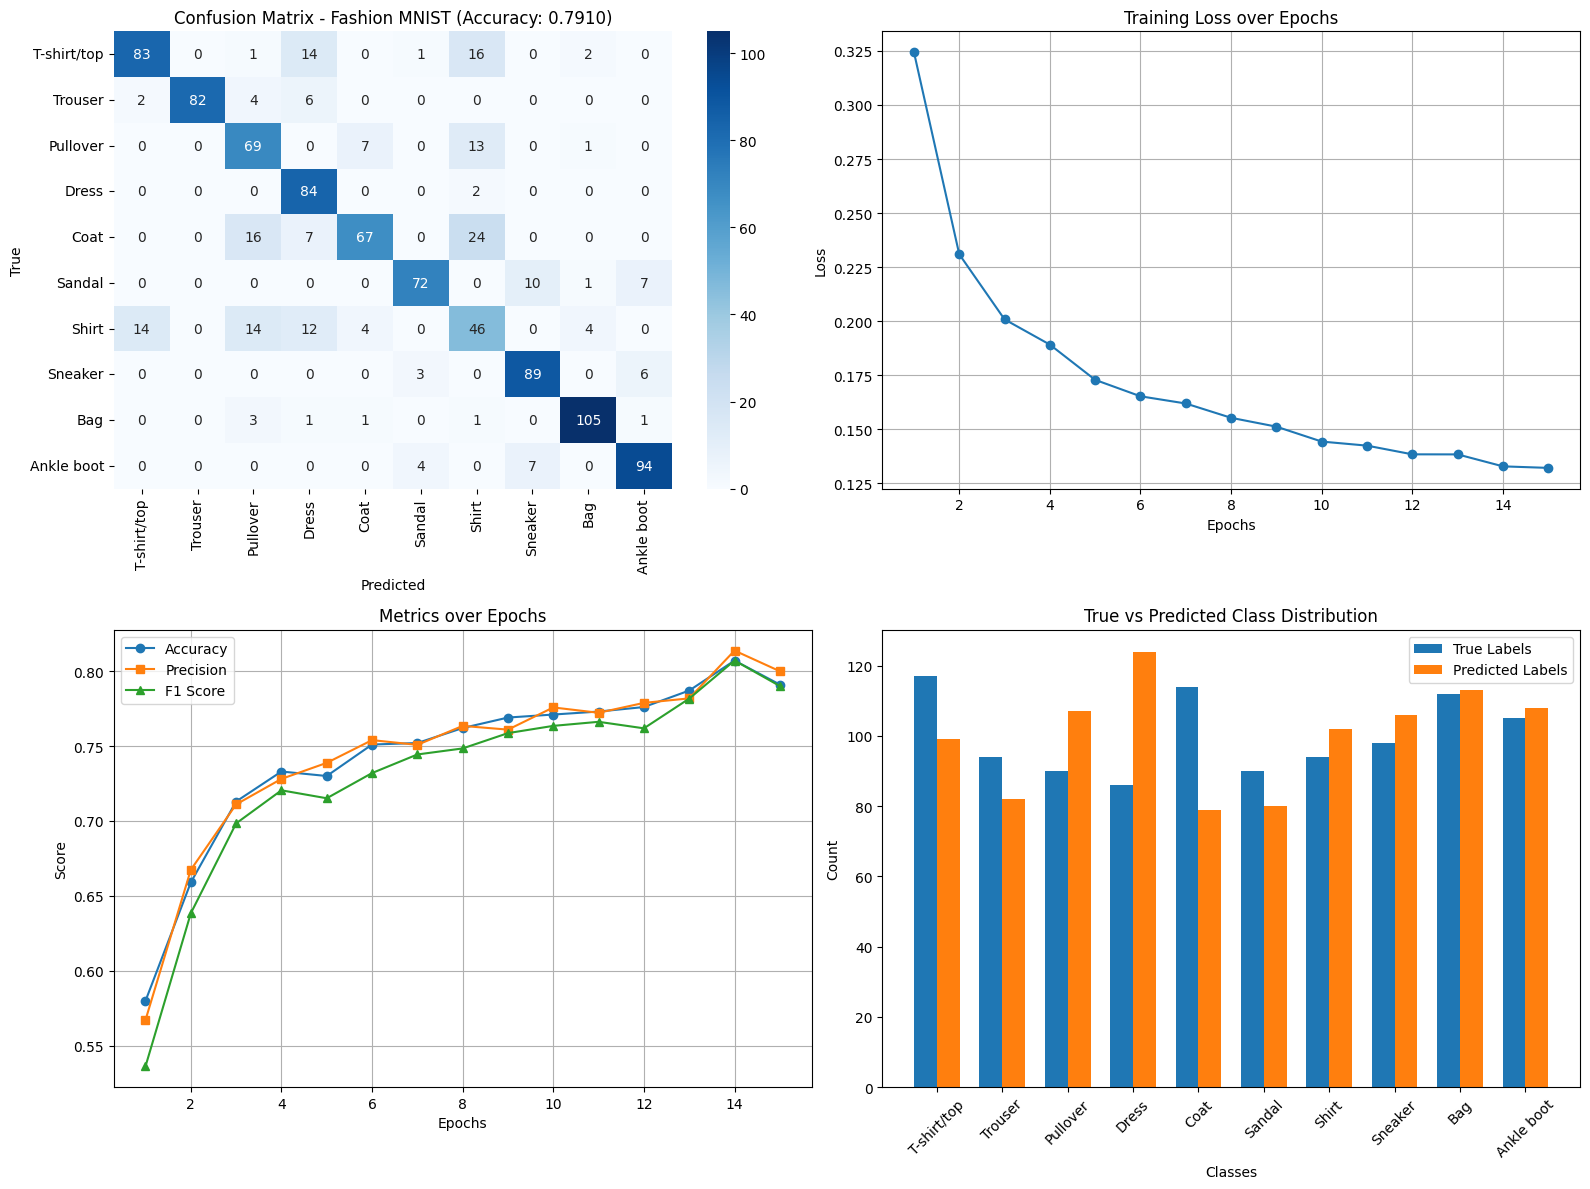

Visualizing true and predicted images...


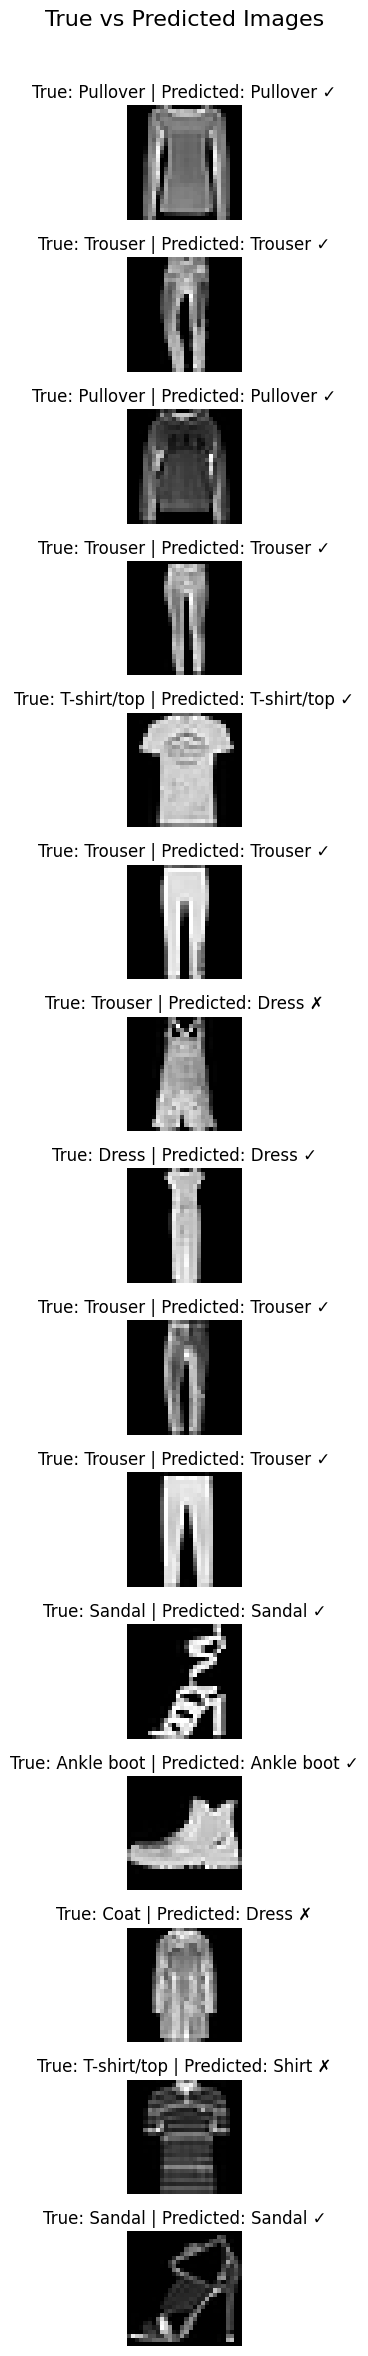

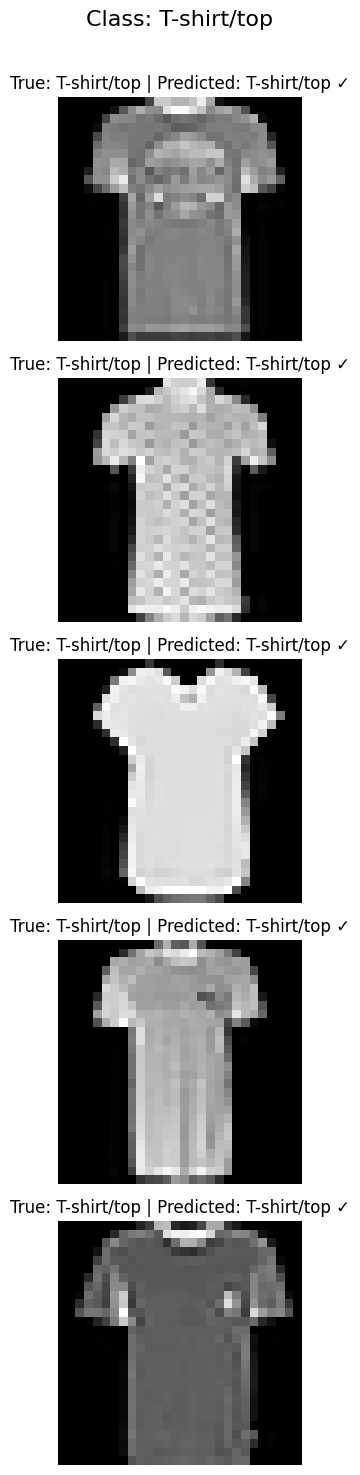

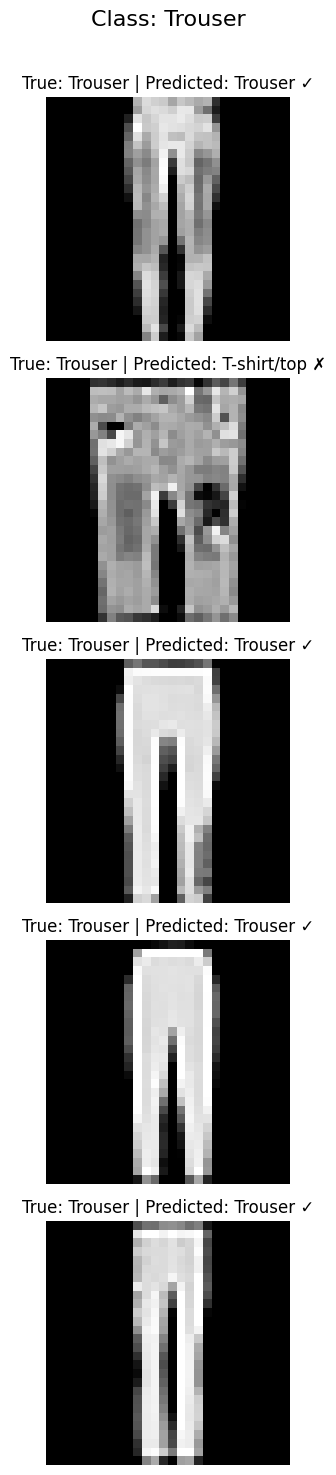

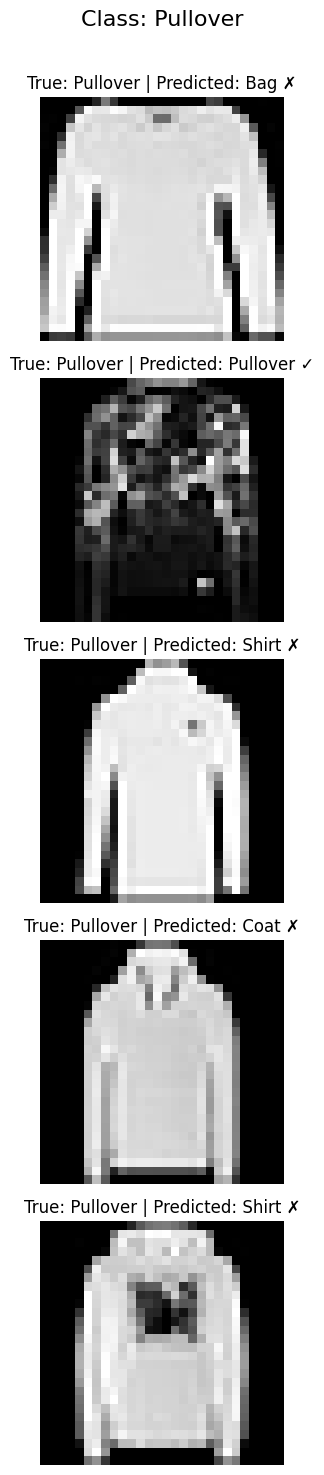

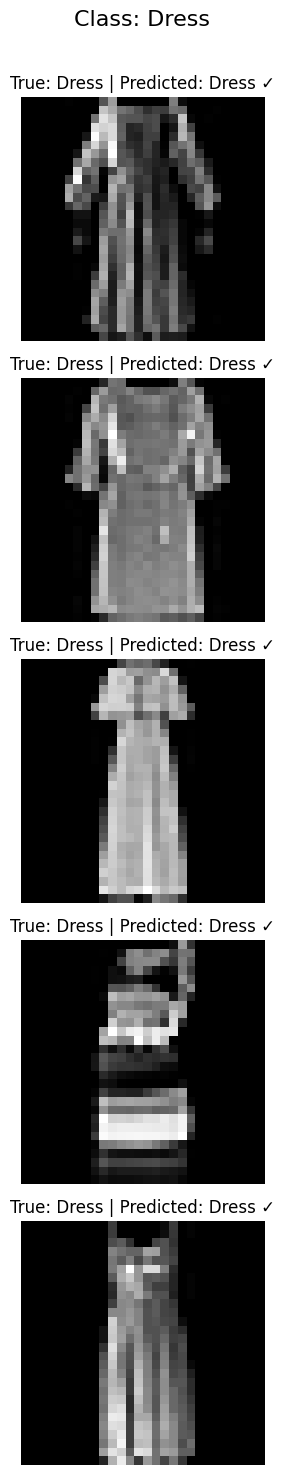

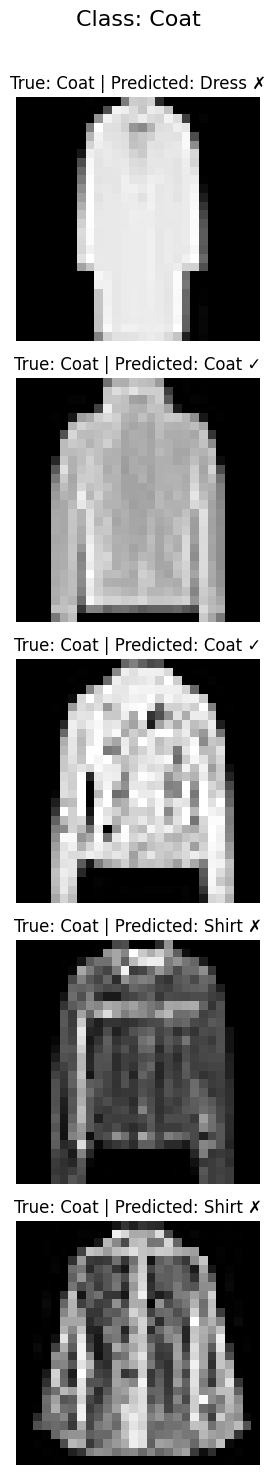

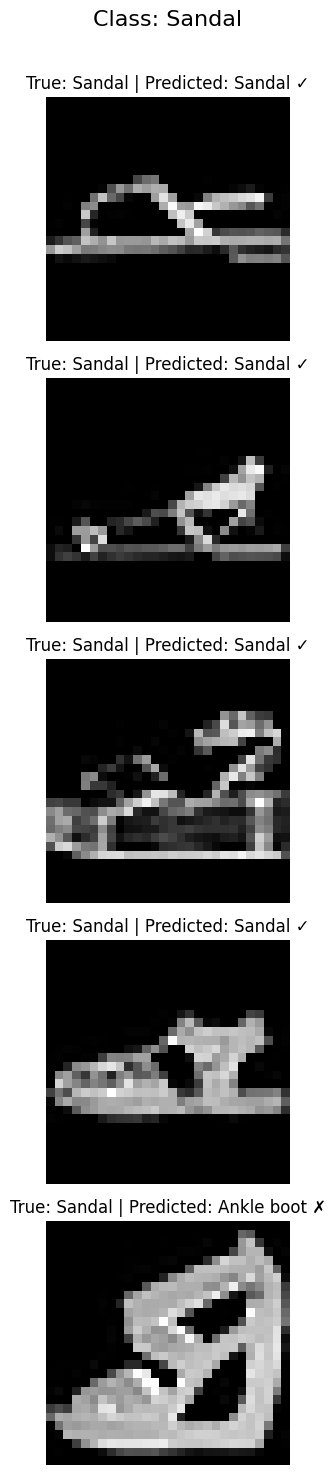

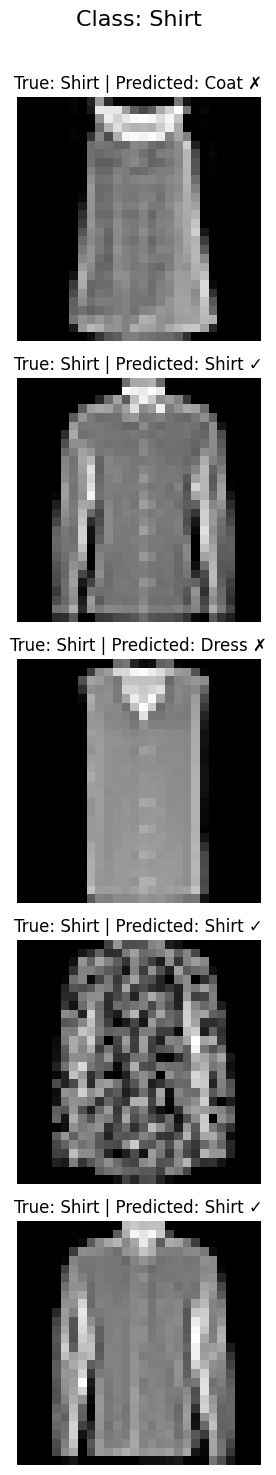

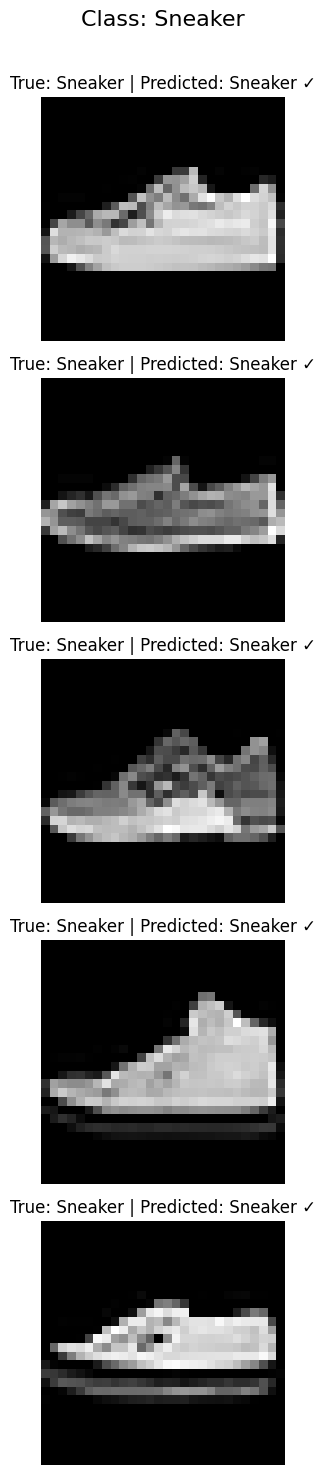

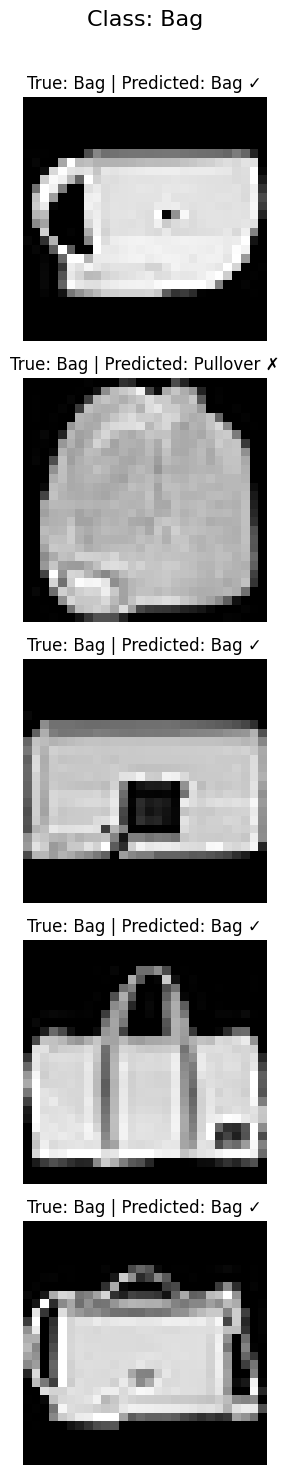

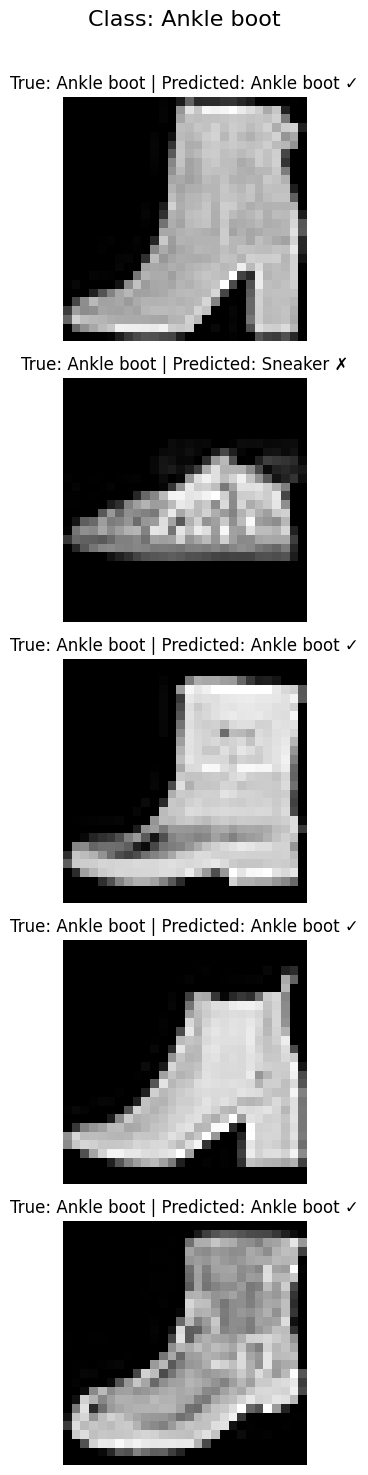

Training complete!
Final accuracy: 0.7910
Final precision: 0.7999
Final F1 score: 0.7900
Total training time: 213.89 seconds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, f1_score, classification_report
import time

# Set random seed for reproducibility
np.random.seed(42)

# Load Fashion MNIST dataset using Keras
print("Loading Fashion MNIST dataset...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Fashion MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Further reduce dataset size for faster execution
train_size = 5000  # Use only 5000 training examples
test_size = 1000  # Use only 1000 test examples

# Randomly sample indices
train_indices = np.random.choice(X_train.shape[0], size=train_size, replace=False)
test_indices = np.random.choice(X_test.shape[0], size=test_size, replace=False)

X_train = X_train[train_indices]
y_train = y_train[train_indices]
X_test = X_test[test_indices]
y_test = y_test[test_indices]

print(f"Using {train_size} training samples and {test_size} test samples")

# Store original test images before preprocessing for later visualization
X_test_original = X_test.copy()

# Data preprocessing
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reduce dimensionality to speed up training
# Take every other row and column (downsampling by factor of 2)
X_train = X_train[:, ::2, ::2]
X_test = X_test[:, ::2, ::2]

print(f"Reduced image size: {X_train.shape[1]}x{X_train.shape[2]}")

# Reshape data for LSTM input (each row is a timestep)
timesteps = X_train.shape[1]  # Number of rows (14 after downsampling)
features = X_train.shape[2]   # Number of columns (14 after downsampling)

X_train = X_train.reshape(X_train.shape[0], timesteps, features)
X_test = X_test.reshape(X_test.shape[0], timesteps, features)

# Convert labels to one-hot encoding
def to_one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_one_hot = to_one_hot(y_train)
y_test_one_hot = to_one_hot(y_test)

# Parameters for fast training
input_size = features      # Each row is a time step
# CHANGED: Increased hidden size from 128 to 192 for potentially better representation capacity
hidden_size = 192          # Increased hidden size for better representation capacity
output_size = 10           # 10 classes
# CHANGED: Decreased learning rate from 0.01 to 0.005 for more stable training
learning_rate = 0.005      # Lower learning rate for more stable training
batch_size = 64            # Batch size kept the same as requested
# CHANGED: Increased epochs from 10 to 15 for potentially better convergence
epochs = 15                # Increased from 10 to 15 epochs

# Helper functions with optimized implementations
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -10, 10)))

def dsigmoid(y):
    return y * (1 - y)

def tanh(x):
    return np.tanh(x)

def dtanh(y):
    return 1 - y * y

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    m = y_pred.shape[0]
    epsilon = 1e-10
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    log_likelihood = -np.log(np.sum(y_pred * y_true, axis=1))
    return np.sum(log_likelihood) / m

# Efficient Xavier/Glorot initialization
def xavier_init(fan_in, fan_out):
    limit = np.sqrt(6 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

# Simplified LSTM implementation for speed
class SimplifiedLSTM:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights for combined gates (more efficient)
        # Combined weights for [forget, input, candidate, output] gates
        self.Wx = xavier_init(input_size, 4 * hidden_size)
        self.Wh = xavier_init(hidden_size, 4 * hidden_size)

        # Biases - with forget gate bias initialized to 1.0
        self.b = np.zeros((1, 4 * hidden_size))
        self.b[:, :hidden_size] = 1.0  # Forget gate bias

        # Output layer
        self.Wy = xavier_init(hidden_size, output_size)
        self.by = np.zeros((1, output_size))

        # Store dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def forward(self, x):
        # x shape: (batch_size, time_steps, input_size)
        batch_size, time_steps, _ = x.shape

        # Initialize hidden state and cell state
        h = np.zeros((batch_size, self.hidden_size))
        c = np.zeros((batch_size, self.hidden_size))

        # Pre-allocate memory for all hidden states (for backprop)
        h_states = np.zeros((batch_size, time_steps + 1, self.hidden_size))
        c_states = np.zeros((batch_size, time_steps + 1, self.hidden_size))

        # Store gate values for backpropagation
        f_gates = np.zeros((batch_size, time_steps, self.hidden_size))
        i_gates = np.zeros((batch_size, time_steps, self.hidden_size))
        c_tildes = np.zeros((batch_size, time_steps, self.hidden_size))
        o_gates = np.zeros((batch_size, time_steps, self.hidden_size))

        # Set initial states
        h_states[:, 0, :] = h
        c_states[:, 0, :] = c

        # Forward pass through time steps
        for t in range(time_steps):
            # Concatenate operations for efficiency
            concat = np.dot(x[:, t, :], self.Wx) + np.dot(h, self.Wh) + self.b

            # Split the concatenated result into the four gates
            f_gate = sigmoid(concat[:, :self.hidden_size])
            i_gate = sigmoid(concat[:, self.hidden_size:2*self.hidden_size])
            c_tilde = tanh(concat[:, 2*self.hidden_size:3*self.hidden_size])
            o_gate = sigmoid(concat[:, 3*self.hidden_size:])

            # Update cell state
            c = f_gate * c + i_gate * c_tilde

            # Update hidden state
            h = o_gate * tanh(c)

            # Store states and gates for backprop
            h_states[:, t+1, :] = h
            c_states[:, t+1, :] = c

            f_gates[:, t, :] = f_gate
            i_gates[:, t, :] = i_gate
            c_tildes[:, t, :] = c_tilde
            o_gates[:, t, :] = o_gate

        # Final output
        y_pred = np.dot(h, self.Wy) + self.by
        probs = softmax(y_pred)

        # Cache for backward pass
        self.cache = {
            'x': x,
            'h_states': h_states,
            'c_states': c_states,
            'f_gates': f_gates,
            'i_gates': i_gates,
            'c_tildes': c_tildes,
            'o_gates': o_gates,
            'probs': probs
        }

        return probs

    def backward(self, y_true, learning_rate=0.01):
        # Retrieve cached values
        x = self.cache['x']
        h_states = self.cache['h_states']
        c_states = self.cache['c_states']
        f_gates = self.cache['f_gates']
        i_gates = self.cache['i_gates']
        c_tildes = self.cache['c_tildes']
        o_gates = self.cache['o_gates']
        probs = self.cache['probs']

        batch_size, time_steps, _ = x.shape

        # Initialize gradients
        dWx = np.zeros_like(self.Wx)
        dWh = np.zeros_like(self.Wh)
        db = np.zeros_like(self.b)
        dWy = np.zeros_like(self.Wy)
        dby = np.zeros_like(self.by)

        # Gradient for output layer
        dout = probs - y_true  # Direct gradient of softmax + cross-entropy
        dWy = np.dot(h_states[:, -1, :].T, dout)
        dby = np.sum(dout, axis=0, keepdims=True)

        # Initialize gradients for hidden state and cell state
        dh_next = np.dot(dout, self.Wy.T)
        dc_next = np.zeros((batch_size, self.hidden_size))

        # Backpropagation through time with faster vectorized operations
        for t in reversed(range(time_steps)):
            # Current hidden state and cell state
            h_prev = h_states[:, t, :]
            c_prev = c_states[:, t, :]
            h = h_states[:, t+1, :]
            c = c_states[:, t+1, :]

            # Current gate values
            f_gate = f_gates[:, t, :]
            i_gate = i_gates[:, t, :]
            c_tilde = c_tildes[:, t, :]
            o_gate = o_gates[:, t, :]

            # Gradient for output gate
            do = dh_next * tanh(c)
            do_input = do * dsigmoid(o_gate)

            # Gradient for cell state
            dc = dc_next + dh_next * o_gate * dtanh(tanh(c))

            # Gradient for forget gate
            df = dc * c_prev
            df_input = df * dsigmoid(f_gate)

            # Gradient for input gate
            di = dc * c_tilde
            di_input = di * dsigmoid(i_gate)

            # Gradient for candidate cell state
            dc_tilde = dc * i_gate
            dc_tilde_input = dc_tilde * dtanh(c_tilde)

            # Combine gate gradients for efficient weight updates
            dgate = np.concatenate((df_input, di_input, dc_tilde_input, do_input), axis=1)

            # Gradients for weights
            dWx += np.dot(x[:, t, :].T, dgate)
            dWh += np.dot(h_prev.T, dgate)
            db += np.sum(dgate, axis=0, keepdims=True)

            # Gradient for input at this time step
            dx_t = np.dot(dgate, self.Wx.T)

            # Gradient for hidden state at previous time step
            dh_prev = np.dot(dgate, self.Wh.T)

            # Gradient for cell state at previous time step
            dc_prev = dc * f_gate

            # Set up for next iteration
            dh_next = dh_prev
            dc_next = dc_prev

        # Update parameters with gradient clipping
        # CHANGED: Modified gradient clipping from [-5, 5] to [-3, 3] for more conservative updates
        def clip_grad(grad):
            return np.clip(grad, -3, 3)

        # Update model parameters
        self.Wx -= learning_rate * clip_grad(dWx)
        self.Wh -= learning_rate * clip_grad(dWh)
        self.b -= learning_rate * clip_grad(db)
        self.Wy -= learning_rate * clip_grad(dWy)
        self.by -= learning_rate * clip_grad(dby)

        return np.sum((probs - y_true) ** 2) / (2 * batch_size)  # Return MSE for monitoring

    def train(self, X_train, y_train, X_test, y_test, learning_rate, batch_size, epochs):
        num_samples = X_train.shape[0]
        num_batches = num_samples // batch_size

        # Training history
        train_losses = []
        test_accuracies = []
        test_precisions = []
        test_f1_scores = []

        # Time tracking
        start_total = time.time()

        print("Starting training...")
        for epoch in range(epochs):
            epoch_start = time.time()

            # Learning rate decay
            # CHANGED: Modified learning rate decay factor from 0.2 to 0.1 for slower decay
            current_lr = learning_rate / (1 + 0.1 * epoch)

            # Shuffle training data
            indices = np.random.permutation(num_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]

            epoch_loss = 0

            # Training loop with batch processing
            for batch in range(num_batches):
                batch_start = batch * batch_size
                batch_end = min(batch_start + batch_size, num_samples)

                X_batch = X_train_shuffled[batch_start:batch_end]
                y_batch = y_train_shuffled[batch_start:batch_end]

                # Forward pass
                probs = self.forward(X_batch)

                # Backward pass with parameter update
                batch_loss = self.backward(y_batch, current_lr)
                epoch_loss += batch_loss

                # Print progress less frequently
                if batch % max(1, num_batches // 5) == 0:
                    print(f"Epoch {epoch+1}/{epochs}, Batch {batch+1}/{num_batches}, Loss: {batch_loss:.4f}")

            # Compute average loss for epoch
            avg_loss = epoch_loss / num_batches
            train_losses.append(avg_loss)

            # Evaluate on test set
            correct = 0
            all_predictions = []
            all_true_labels = []

            for i in range(0, len(X_test), batch_size):
                X_test_batch = X_test[i:i+batch_size]
                y_test_batch = y_test[i:i+batch_size]

                # Get predictions
                probs = self.forward(X_test_batch)
                predictions = np.argmax(probs, axis=1)
                true_labels = np.argmax(y_test_batch, axis=1)

                # Store predictions and true labels
                all_predictions.extend(predictions)
                all_true_labels.extend(true_labels)

                # Count correct predictions
                correct += np.sum(predictions == true_labels)

            # Calculate accuracy
            accuracy = correct / len(X_test)
            test_accuracies.append(accuracy)

            # Calculate precision and F1 score (macro average)
            precision = precision_score(all_true_labels, all_predictions, average='macro', zero_division=0)
            f1 = f1_score(all_true_labels, all_predictions, average='macro', zero_division=0)

            test_precisions.append(precision)
            test_f1_scores.append(f1)

            # Print epoch summary with precision and F1 score
            epoch_time = time.time() - epoch_start
            print(f"Epoch {epoch+1}/{epochs} completed in {epoch_time:.2f}s")
            print(f"Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}")

            # Early stopping if accuracy is very good
            if accuracy >= 0.85:
                print(f"Early stopping at epoch {epoch+1} with accuracy {accuracy:.4f}")
                break

            # Check time
            elapsed = time.time() - start_total
            print(f"Total time elapsed: {elapsed:.2f}s")

            # Project total time
            projected_time = elapsed * epochs / (epoch + 1)
            if projected_time > 600:  # 10 minutes in seconds
                print(f"Warning: Projected total time {projected_time:.2f}s exceeds 10 minutes")
                print("Reducing learning rate to speed up convergence")
                learning_rate *= 1.5  # Try to speed up learning

        total_time = time.time() - start_total
        print(f"Training completed in {total_time:.2f} seconds")

        # Generate final predictions
        all_predictions = []
        all_true_labels = []

        for i in range(0, len(X_test), batch_size):
            X_test_batch = X_test[i:i+batch_size]
            y_test_batch = y_test[i:i+batch_size]

            probs = self.forward(X_test_batch)
            predictions = np.argmax(probs, axis=1)
            true_labels = np.argmax(y_test_batch, axis=1)

            all_predictions.extend(predictions)
            all_true_labels.extend(true_labels)

        # Convert to numpy arrays for easier handling
        all_predictions = np.array(all_predictions)
        all_true_labels = np.array(all_true_labels)

        # Create confusion matrix
        cm = confusion_matrix(all_true_labels, all_predictions)

        # Calculate final metrics
        final_accuracy = np.mean(all_predictions == all_true_labels)
        final_precision = precision_score(all_true_labels, all_predictions, average='macro', zero_division=0)
        final_f1 = f1_score(all_true_labels, all_predictions, average='macro', zero_division=0)

        # Get detailed classification report
        report = classification_report(all_true_labels, all_predictions, target_names=class_names)
        print("\nClassification Report:")
        print(report)

        # Create a figure for multiple plots
        plt.figure(figsize=(16, 12))

        # Plot 1: Confusion Matrix
        plt.subplot(2, 2, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - Fashion MNIST (Accuracy: {final_accuracy:.4f})')

        # Plot 2: Loss over epochs
        plt.subplot(2, 2, 2)
        plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss over Epochs')
        plt.grid(True)

        # Plot 3: Accuracy, Precision and F1 Score over epochs
        plt.subplot(2, 2, 3)
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', label='Accuracy')
        plt.plot(range(1, len(test_precisions) + 1), test_precisions, marker='s', label='Precision')
        plt.plot(range(1, len(test_f1_scores) + 1), test_f1_scores, marker='^', label='F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.title('Metrics over Epochs')
        plt.legend()
        plt.grid(True)

        # Plot 4: True vs Predicted class distribution bar graph
        plt.subplot(2, 2, 4)

        # Count occurrences of each class
        true_counts = np.bincount(all_true_labels, minlength=10)
        pred_counts = np.bincount(all_predictions, minlength=10)

        # Set width of bars
        width = 0.35
        x = np.arange(len(class_names))

        # Create bars
        plt.bar(x - width/2, true_counts, width, label='True Labels')
        plt.bar(x + width/2, pred_counts, width, label='Predicted Labels')

        # Add labels and title
        plt.xlabel('Classes')
        plt.ylabel('Count')
        plt.title('True vs Predicted Class Distribution')
        plt.xticks(x, class_names, rotation=45)
        plt.legend()

        # Adjust layout and show plots
        plt.tight_layout()
        plt.show()

        # Visualize true and predicted images
        def visualize_true_and_predicted(X_original, true_labels, predictions, class_names):
            # Create a grid of true vs predicted images
            plt.figure(figsize=(15, 24))
            plt.suptitle("True vs Predicted Images", fontsize=16)

            # Select 15 random samples to visualize
            n_samples = min(15, len(true_labels))
            indices = np.random.choice(len(true_labels), size=n_samples, replace=False)

            for i, idx in enumerate(indices):
                plt.subplot(n_samples, 1, i+1)
                plt.imshow(X_original[idx], cmap='gray')

                # Title shows both true and predicted labels
                matching = "✓" if true_labels[idx] == predictions[idx] else "✗"
                plt.title(f"True: {class_names[true_labels[idx]]} | Predicted: {class_names[predictions[idx]]} {matching}",
                          fontsize=12)
                plt.axis('off')

            plt.tight_layout(rect=[0, 0, 1, 0.97])
            plt.show()

            # Create a separate visualization for each class
            for class_idx in range(len(class_names)):
                # Find samples with this true class
                class_indices = np.where(true_labels == class_idx)[0]
                if len(class_indices) == 0:
                    continue

                # Sample up to 5 images from this class
                sample_size = min(5, len(class_indices))
                sample_indices = np.random.choice(class_indices, size=sample_size, replace=False)

                plt.figure(figsize=(15, 3*sample_size))
                plt.suptitle(f"Class: {class_names[class_idx]}", fontsize=16)

                for i, idx in enumerate(sample_indices):
                    plt.subplot(sample_size, 1, i+1)
                    plt.imshow(X_original[idx], cmap='gray')

                    matching = "✓" if class_idx == predictions[idx] else "✗"
                    plt.title(f"True: {class_names[class_idx]} | Predicted: {class_names[predictions[idx]]} {matching}",
                              fontsize=12)
                    plt.axis('off')

                plt.tight_layout(rect=[0, 0, 1, 0.97])
                plt.show()

        # Call the visualization function
        print("Visualizing true and predicted images...")
        visualize_true_and_predicted(X_test_original, all_true_labels, all_predictions, class_names)

        return {
            'train_losses': train_losses,
            'test_accuracies': test_accuracies,
            'test_precisions': test_precisions,
            'test_f1_scores': test_f1_scores,
            'confusion_matrix': cm,
            'final_accuracy': final_accuracy,
            'final_precision': final_precision,
            'final_f1': final_f1,
            'training_time': total_time,
            'true_counts': true_counts,
            'pred_counts': pred_counts
        }

# Create and train the model
print("Creating simplified LSTM model...")
lstm_model = SimplifiedLSTM(input_size=features, hidden_size=hidden_size, output_size=output_size)

# Train the model
print(f"Starting training with {train_size} samples, batch size {batch_size}, and {epochs} epochs")
history = lstm_model.train(
    X_train, y_train_one_hot,
    X_test, y_test_one_hot,
    learning_rate=learning_rate,
    batch_size=batch_size,
    epochs=epochs
)

print("Training complete!")
print(f"Final accuracy: {history['final_accuracy']:.4f}")
print(f"Final precision: {history['final_precision']:.4f}")
print(f"Final F1 score: {history['final_f1']:.4f}")
print(f"Total training time: {history['training_time']:.2f} seconds")